<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Exam_preparation/time_series_forecasting_wheater_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Climate data forecasting

In [1]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip

--2021-09-15 09:45:46--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.201.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.08s   

2021-09-15 09:45:46 (163 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



## Data Preparation

In [2]:
#Extract the Zipfile
import zipfile
with zipfile.ZipFile("/content/jena_climate_2009_2016.csv.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
import pandas as pd
df = pd.read_csv("/content/jena_climate_2009_2016.csv", index_col=["Date Time"])
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420551 entries, 01.01.2009 00:10:00 to 01.01.2017 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420551 non-null  float64
 1   T (degC)         420551 non-null  float64
 2   Tpot (K)         420551 non-null  float64
 3   Tdew (degC)      420551 non-null  float64
 4   rh (%)           420551 non-null  float64
 5   VPmax (mbar)     420551 non-null  float64
 6   VPact (mbar)     420551 non-null  float64
 7   VPdef (mbar)     420551 non-null  float64
 8   sh (g/kg)        420551 non-null  float64
 9   H2OC (mmol/mol)  420551 non-null  float64
 10  rho (g/m**3)     420551 non-null  float64
 11  wv (m/s)         420551 non-null  float64
 12  max. wv (m/s)    420551 non-null  float64
 13  wd (deg)         420551 non-null  float64
dtypes: float64(14)
memory usage: 48.1+ MB


In [5]:
#Select temperature data only
temperature_data = pd.DataFrame(df["T (degC)"]).rename(columns={"T (degC)": "Temperature"})
temperature_data.head()

,Temperature
Date Time,
01.01.2009 00:10:00,-8.02
01.01.2009 00:20:00,-8.41
01.01.2009 00:30:00,-8.51
01.01.2009 00:40:00,-8.31
01.01.2009 00:50:00,-8.27


Text(0, 0.5, 'Temperature')

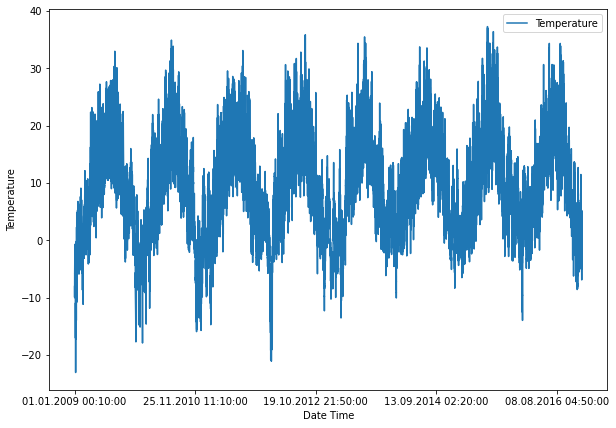

In [6]:
#Plot the series
import matplotlib.pyplot as plt
temperature_data.plot(figsize=(10,7))
plt.ylabel("Temperature")

In [7]:
#Convert series to numpy for normalization
timesteps = temperature_data.index.to_numpy()
temperature = temperature_data["Temperature"].to_numpy()

In [8]:
timesteps[:10], temperature[:10]

(array(['01.01.2009 00:10:00', '01.01.2009 00:20:00',
        '01.01.2009 00:30:00', '01.01.2009 00:40:00',
        '01.01.2009 00:50:00', '01.01.2009 01:00:00',
        '01.01.2009 01:10:00', '01.01.2009 01:20:00',
        '01.01.2009 01:30:00', '01.01.2009 01:40:00'], dtype=object),
 array([-8.02, -8.41, -8.51, -8.31, -8.27, -8.05, -7.62, -7.62, -7.91,
        -8.43]))

In [9]:
temperature = temperature.reshape(-1, 1)

###Data Normalization

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_temperature = scaler.fit_transform(temperature)
scaled_temperature[:10]

array([[0.24863161],
       [0.24216288],
       [0.24050423],
       [0.24382153],
       [0.24448499],
       [0.24813402],
       [0.25526621],
       [0.25526621],
       [0.25045613],
       [0.24183115]])

In [11]:
import numpy as np
scaled_temperature = np.squeeze(scaled_temperature, axis=1)

In [ ]:
#Plot data and check if it´s between 0 and 1
plt.figure(figsize=(10,7))
plt.plot(scaled_temperature)
plt.ylabel("Temperature")

## Helper functions

In [21]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.
  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)
  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [13]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turn a 1D array into a 2D array of sequential windows of window_size
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # 2. Create 2D array of multiple window steps (minus 1 to account for indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T #create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # Get the labelled windows
  windows, labels = windowed_array[:, :-horizon], windowed_array[:, -horizon:]

  return windows, labels

def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

### Make Windows / Train - Test - Split

In [39]:
windows_7, labels_7 = make_windows(scaled_temperature, window_size=7, horizon=1)

In [40]:
train_windows_7, test_windows_7, train_labels_7, test_labels_7 = make_train_test_splits(windows_7, labels_7)

##Modelling Experiments

### Model 1: Dense

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

window_size = 7 
horizon = 1

tf.random.set_seed(42)

#Build the model 
inputs = layers.Input(shape=window_size)
x = layers.Dense(128, activation="relu")(inputs)
outputs = layers.Dense(horizon)(x)
model_1 = tf.keras.Model(inputs, outputs)

In [17]:
#Compile the model 
model_1.compile(loss="mae", optimizer="Adam", metrics=["mae","mse"])

In [ ]:
#Fit the model 
history_model_1 = model_1.fit(train_windows_7, train_labels_7,
                              epochs=500,
                              batch_size=128,
                              verbose=0,
                              validation_data = (test_windows_7, test_labels_7),
                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=0),
                                         tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])

In [19]:
model_1.evaluate(test_windows_7, test_labels_7)

2629/2629 [==============================] - 3s 1ms/step - loss: 0.0023 - mae: 0.0023 - mse: 1.2763e-05


[0.002265905262902379, 0.002265905262902379, 1.2763088307110593e-05]

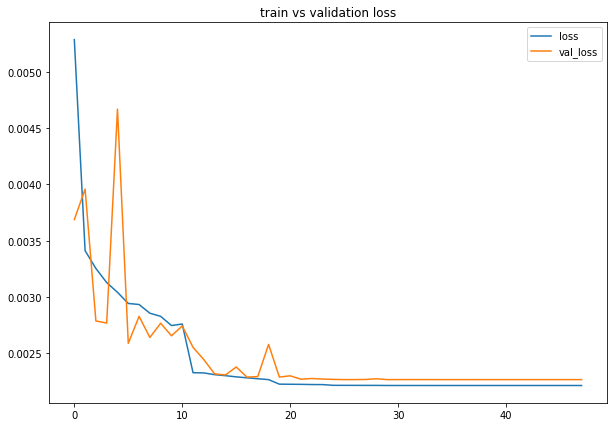

In [20]:
loss = history_model_1.history["loss"]
val_loss = history_model_1.history["val_loss"]

plt.figure(figsize=(10, 7))
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.title("train vs validation loss")
plt.legend()

In [22]:
model_1_preds = make_preds(model_1, test_windows_7)
model_1_results = evaluate_preds(tf.squeeze(test_labels_7),model_1_preds)
model_1_results

{'mae': 0.0022659034,
 'mape': 0.4022108,
 'mse': 1.2763095e-05,
 'rmse': 0.0035725473}

### Model 2 LSTM

#### Prepare Data for LSTM

In [41]:
train_windows_7_expanded = np.expand_dims(train_windows_7, axis=1)
test_windows_7_expanded = np.expand_dims(test_windows_7, axis=1)

In [42]:
train_windows_7_expanded.shape, test_windows_7_expanded.shape

((336435, 1, 7), (84109, 1, 7))

In [43]:
tf.random.set_seed(42)

#Build the model 
inputs = layers.Input(shape=(horizon, window_size))
x = layers.LSTM(4, activation="tanh")(inputs)
outputs = layers.Dense(horizon)(x)
model_2 = tf.keras.Model(inputs, outputs)

In [44]:
#Compile the model 
model_2.compile(loss="mae", optimizer="Adam", metrics=["mse", "mae"])

In [45]:
#Fit the model 
history_model_2 = model_2.fit(train_windows_7_expanded, train_labels_7,
                              epochs=500, 
                              batch_size=128,
                              verbose=0,
                              validation_data=(test_windows_7_expanded, test_labels_7), 
                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=0),
                                         tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])

In [47]:
#Evaluate
model_2.evaluate(test_windows_7_expanded, test_labels_7)

2629/2629 [==============================] - 3s 1ms/step - loss: 0.0025 - mse: 1.5888e-05 - mae: 0.0025


[0.002542627276852727, 1.588814120623283e-05, 0.002542627276852727]

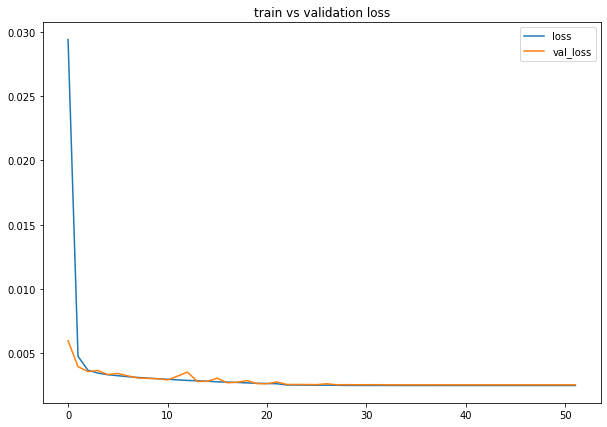

In [48]:
loss = history_model_2.history["loss"]
val_loss = history_model_2.history["val_loss"]

plt.figure(figsize=(10, 7))
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.title("train vs validation loss")
plt.legend()

In [52]:
model_2_preds = make_preds(model_2, test_windows_7_expanded)
model_2_results = evaluate_preds(tf.squeeze(test_labels_7),model_2_preds)
model_2_results

{'mae': 0.0025426266,
 'mape': 0.45158964,
 'mse': 1.5888158e-05,
 'rmse': 0.003985995}